In [2]:
# Copyright (c) OpenMMLab. All rights reserved.
import mimetypes
import os
import time
import glob
from tqdm import tqdm
import cv2
import json_tricks as json
import mmcv
import mmengine
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pickle

from mmpose.apis import inference_topdown
from mmpose.apis import init_model as init_pose_estimator
from mmpose.evaluation.functional import nms
from mmpose.registry import VISUALIZERS
from mmpose.structures import merge_data_samples, split_instances
from mmpose.utils import adapt_mmdet_pipeline
from mmdet.apis import inference_detector, init_detector


########## Load rtm-pose estimator ##############
# Intitalize detector and pose estimator
det_config = 'external/mmpose/projects/rtmpose/rtmdet/hand/rtmdet_nano_320-8xb32_hand.py'
det_ckpt = 'https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmdet_nano_8xb32-300e_hand-267f9c8f.pth'
device = 'cuda:0'
detector = init_detector(det_config, det_ckpt, device=device)
detector.cfg = adapt_mmdet_pipeline(detector.cfg)

# build pose estimator
pose_config = 'external/mmpose/projects/rtmpose/rtmpose/hand_2d_keypoint/rtmpose-m_8xb32-210e_coco-wholebody-hand-256x256.py'
pose_ckpt = 'https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmpose-m_simcc-hand5_pt-aic-coco_210e-256x256-74fb594_20230320.pth'
pose_estimator = init_pose_estimator(
    pose_config,
    pose_ckpt,
    device=device,
    cfg_options=dict(model=dict(test_cfg=dict(output_heatmaps=False))))

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmdet_nano_8xb32-300e_hand-267f9c8f.pth


/home/jinxu/code/Ego4d_mmpose/Ego4d/ego4d/internal/human_pose/external/mmpose/mmpose/datasets/datasets/utils.py:102: UserWarning: The metainfo config file "configs/_base_/datasets/onehand10k.py" does not exist. A matched config file "/home/jinxu/code/Ego4d_mmpose/Ego4d/ego4d/internal/human_pose/external/mmpose/mmpose/.mim/configs/_base_/datasets/onehand10k.py" will be used instead.
  warnings.warn(
/home/jinxu/miniconda3/envs/human_pose_mmpose/lib/python3.9/site-packages/mmdet/apis/inference.py:108: UserWarning: palette does not exist, random is used by default. You can also set the palette to customize.
  warnings.warn(


Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmpose-m_simcc-hand5_pt-aic-coco_210e-256x256-74fb594_20230320.pth


#### Demo

Bbox detection

In [4]:
#####################################
test_case = "sfu_cooking_007_3_18060-18210"
#####################################

img_dir_path = f"/media/jinxu/New Volume/ego4dData/cache/{test_case}/frames/aria01_rgb"
all_img_path = sorted(glob.glob(os.path.join(img_dir_path, '*')))
img = all_img_path[68]

######### Bbox with pretrained detector ############
det_result = inference_detector(detector, img)
pred_instance = det_result.pred_instances.cpu().numpy()
bboxes = np.concatenate(
    (pred_instance.bboxes, pred_instance.scores[:, None]), axis=1)
# bboxes = bboxes[np.logical_and(pred_instance.labels == 0, pred_instance.scores > 0.3)]
# bboxes = bboxes[nms(bboxes, 0.3), :4]

/home/jinxu/miniconda3/envs/human_pose_mmpose/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343997789/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


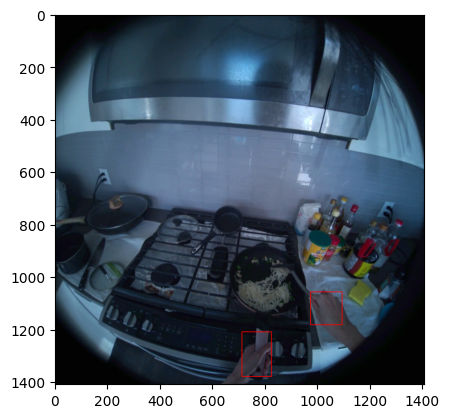

In [11]:
# Manually select first two bboxes
bboxes = bboxes[:2,:4] # Get first two bboxes

# Visualization
image = np.array(Image.open(img))
plt.imshow(image)
bbox_vis = bboxes.astype(np.int64)
for curr_vis_bbox in bbox_vis:
    cv2.rectangle(image, curr_vis_bbox[:2], curr_vis_bbox[2:], color=(255,0,0), thickness=2);
plt.imshow(image)

Hand pose2d estimation

In [12]:
pose_results = inference_topdown(pose_estimator, img, bboxes)
data_samples = merge_data_samples(pose_results)

kpts = data_samples.pred_instances.keypoints
print(kpts.shape)

(2, 21, 2)


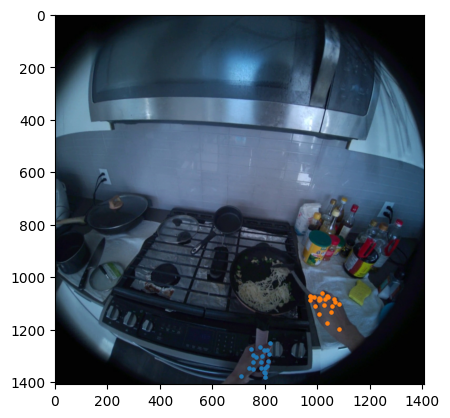

In [13]:
image = np.array(Image.open(img))
vis_kpts = kpts.astype(np.int64)
for curr_kpt in vis_kpts:
    plt.scatter(curr_kpt[:,0], curr_kpt[:,1], s=5)
plt.imshow(image)